# This notebook performs a simple characterization of the data:
## (Figure 8 of the paper)
- Create a table to visualize most frequent words vs their predictions
- Prove the importance of Attention ('echo' and 'rm' examples)

## Prepare data
***

### Import predictions

In [1]:
from tqdm import tqdm
tqdm.pandas()
import pandas as pd 
predicted_corpus = pd.read_parquet(f"../1.Dataset/Inference_with_predictions/logprecis_predictions.parquet")
predicted_corpus.head(2)

,session_id,sequence_words,sequence_predictions
0,0,"[enable, ;, system, ;, shell, ;, sh, ;, cat, /...","[Discovery, Discovery, Discovery, Discovery, D..."
1,1,"[enable, ;, system, ;, shell, ;, sh, ;, cat, /...","[Discovery, Discovery, Discovery, Discovery, D..."


Concatenate `sequence words` and `sequence_predictions`

In [2]:
predicted_corpus["session"] = predicted_corpus["sequence_words"].progress_apply(
                                                lambda split_session: " ".join(split_session))
predicted_corpus["predictions"] = predicted_corpus["sequence_predictions"].progress_apply(
                                                lambda split_prediction: " -- ".join(split_prediction))
print(f"Corpus contains {predicted_corpus.shape[0]:,} sessions ({predicted_corpus.session.nunique():,} unique)")
print(f"Furthermore, corpus contains {predicted_corpus.predictions.nunique()} unique fingerprints")
predicted_corpus.head(2)

100%|██████████| 233035/233035 [00:01<00:00, 145222.27it/s]


Corpus contains 233,035 sessions (233,035 unique)
Furthermore, corpus contains 1673 unique fingerprints


,session_id,sequence_words,sequence_predictions,session,predictions
0,0,"[enable, ;, system, ;, shell, ;, sh, ;, cat, /...","[Discovery, Discovery, Discovery, Discovery, D...",enable ; system ; shell ; sh ; cat /proc/mount...,Discovery -- Discovery -- Discovery -- Discove...
1,1,"[enable, ;, system, ;, shell, ;, sh, ;, cat, /...","[Discovery, Discovery, Discovery, Discovery, D...",enable ; system ; shell ; sh ; cat /proc/mount...,Discovery -- Discovery -- Discovery -- Discove...


### Join predictions with full dataset (containing metadata)

Load original data (reset indexes to numeric)

In [3]:
full_corpus = pd.read_csv(f"../1.Dataset/Inference/cyberlab_data.csv")
if "session_id" in full_corpus.columns:
    full_corpus = full_corpus.drop("session_id", axis=1)
full_corpus = full_corpus.reset_index().rename({"index":"session_id"}, axis=1)
full_corpus.head(2)

,session_id,session,sensor,first_timestamp,date
0,0,enable ; system ; shell ; sh ; cat /proc/mount...,eea5dc653b37,2019-06-04 09:45:11.151186+00:00,2019-06-04
1,1,enable ; system ; shell ; sh ; cat /proc/mount...,eea5dc653b37,2019-06-04 09:45:50.396610+00:00,2019-06-04


Join with predictions

In [4]:
joined_corpus = full_corpus[["session_id", "first_timestamp", "sensor", "date"]].merge(predicted_corpus[["session_id", "sequence_words", "sequence_predictions"]], on="session_id")
joined_corpus.head(2)

,session_id,first_timestamp,sensor,date,sequence_words,sequence_predictions
0,0,2019-06-04 09:45:11.151186+00:00,eea5dc653b37,2019-06-04,"[enable, ;, system, ;, shell, ;, sh, ;, cat, /...","[Discovery, Discovery, Discovery, Discovery, D..."
1,1,2019-06-04 09:45:50.396610+00:00,eea5dc653b37,2019-06-04,"[enable, ;, system, ;, shell, ;, sh, ;, cat, /...","[Discovery, Discovery, Discovery, Discovery, D..."


## General Characterization
***

#### How many words per Tactic?

In [5]:
sessions_date_predictions = joined_corpus[["sequence_words", "sequence_predictions", "date"]]
exploded_df = sessions_date_predictions[["sequence_words", "sequence_predictions", "date"]].explode(["sequence_words", "sequence_predictions"])
print(f"Exploded dataset contains {exploded_df.shape[0]:,} rows and {exploded_df.shape[1]:,} columns")
exploded_df.head(2)

Exploded dataset contains 28,150,954 rows and 3 columns


,sequence_words,sequence_predictions,date
0,enable,Discovery,2019-06-04
0,;,Discovery,2019-06-04


In [6]:
tot_words = exploded_df.shape[0]
words_per_tactics = exploded_df.value_counts("sequence_predictions").reset_index(name="words_x_tactic").rename({"sequence_predictions":"Tactics"}, axis=1)
words_per_tactics["%_over_corpus"] = words_per_tactics.words_x_tactic.apply(lambda el: round(el/tot_words*100,2))
print(f"There are {tot_words:,} Unix words in the dataset ({exploded_df.sequence_words.nunique():,} unique)")
display(words_per_tactics)

There are 28,150,954 Unix words in the dataset (400,997 unique)


,Tactics,words_x_tactic,%_over_corpus
0,Discovery,22865169,81.22
1,Persistence,3363033,11.95
2,Execution,1771002,6.29
3,Defense Evasion,138774,0.49
4,Harmless,8952,0.03
5,Other,3785,0.01
6,Impact,239,0.00


## Words vs Tactics
***

##### Now, visualize prediction for TOP10 words
Idea is to focus on 1st session (in time) per fingerprint. 

This is done to avoid being too influenced by very similar and frequent sessions (more fair wrt rarer sessions).

**Notice**: message would be valid also with all sessions, but analysis would change wrt paper (we should consider other commands).

Select oldest session per fingerprint among available

In [7]:
joined_corpus["fingerprint"] = joined_corpus["sequence_predictions"].apply(lambda predictions: " -- ".join(predictions))
unique_corpus = joined_corpus.sort_values(by = "date").drop_duplicates("fingerprint")
unique_corpus.head(2)

,session_id,first_timestamp,sensor,date,sequence_words,sequence_predictions,fingerprint
0,0,2019-06-04 09:45:11.151186+00:00,eea5dc653b37,2019-06-04,"[enable, ;, system, ;, shell, ;, sh, ;, cat, /...","[Discovery, Discovery, Discovery, Discovery, D...",Discovery -- Discovery -- Discovery -- Discove...
59,59,2019-06-04 19:26:26.930419+00:00,eea5dc653b37,2019-06-04,"[enable, ;, system, ;, shell, ;, sh, ;, cat, /...","[Discovery, Discovery, Discovery, Discovery, D...",Discovery -- Discovery -- Discovery -- Discove...


Now, explode commands and compute the words occurrences

In [8]:
words_occurrences = exploded_df.value_counts("sequence_words").reset_index(name="words_occurrences").rename({"sequence_words":"Unix_command"}, axis=1)
words_occurrences.head(2)

,Unix_command,words_occurrences
0,;,5097003
1,|,3277051


Focus on (most frequent) words reported in the paper (figure 8)

In [9]:
figure_commands = ["grep", ".ssh", "cat", "passwd", "wget", "/bin/busybox", 
                    "chmod", "bash", "mkdir", "sh", "echo", "cd", "rm"]
filtered_commands = exploded_df[exploded_df.sequence_words.isin(figure_commands)]
filtered_commands = filtered_commands[["sequence_words", "sequence_predictions"]]\
                                .rename({"sequence_words":"Unix_command", "sequence_predictions":"prediction"}, axis=1)
filtered_commands["word_counter"] = 1 #useful for following pivot table
filtered_commands.head(2)

,Unix_command,prediction,word_counter
0,sh,Discovery,1
0,cat,Discovery,1


Pivot table commands vs tattics

In [10]:
#filtered_commands.groupby("Unix_command").
table = pd.pivot_table(filtered_commands, values="word_counter", columns=['Unix_command'], index=['prediction'], aggfunc="sum")
table = table[figure_commands]/table[figure_commands].sum(axis=0) #Reorder columns as in paper and normalize column-wise
table

Unix_command,grep,.ssh,cat,passwd,wget,/bin/busybox,chmod,bash,mkdir,sh,echo,cd,rm
prediction,,,,,,,,,,,,,
Defense Evasion,NaN,NaN,NaN,NaN,NaN,0.133289,NaN,NaN,0.000163,0.000879,NaN,0.000182,0.046316
Discovery,9.996965e-01,0.000365,0.970204,0.021643,0.752429,0.737845,0.051278,0.000335,0.104102,0.623118,0.327630,0.143020,0.936450
Execution,7.821764e-07,0.000091,0.029794,0.000778,0.247145,0.128854,0.504990,0.300737,0.000981,0.375967,0.102050,0.769338,0.004643
Harmless,NaN,NaN,NaN,0.000598,0.000384,0.000012,NaN,0.000621,0.000490,0.000035,0.000921,0.000024,0.000004
Impact,NaN,0.000183,NaN,NaN,NaN,NaN,NaN,NaN,0.000490,NaN,NaN,0.000024,0.000013
Other,NaN,NaN,NaN,NaN,0.000043,NaN,NaN,NaN,NaN,NaN,0.000327,0.000981,NaN
Persistence,3.027023e-04,0.999360,0.000003,0.976981,NaN,NaN,0.443732,0.698307,0.893773,NaN,0.569072,0.086432,0.012574


### Equivalent of Figure 8 in the paper (dataset there was POLITO)

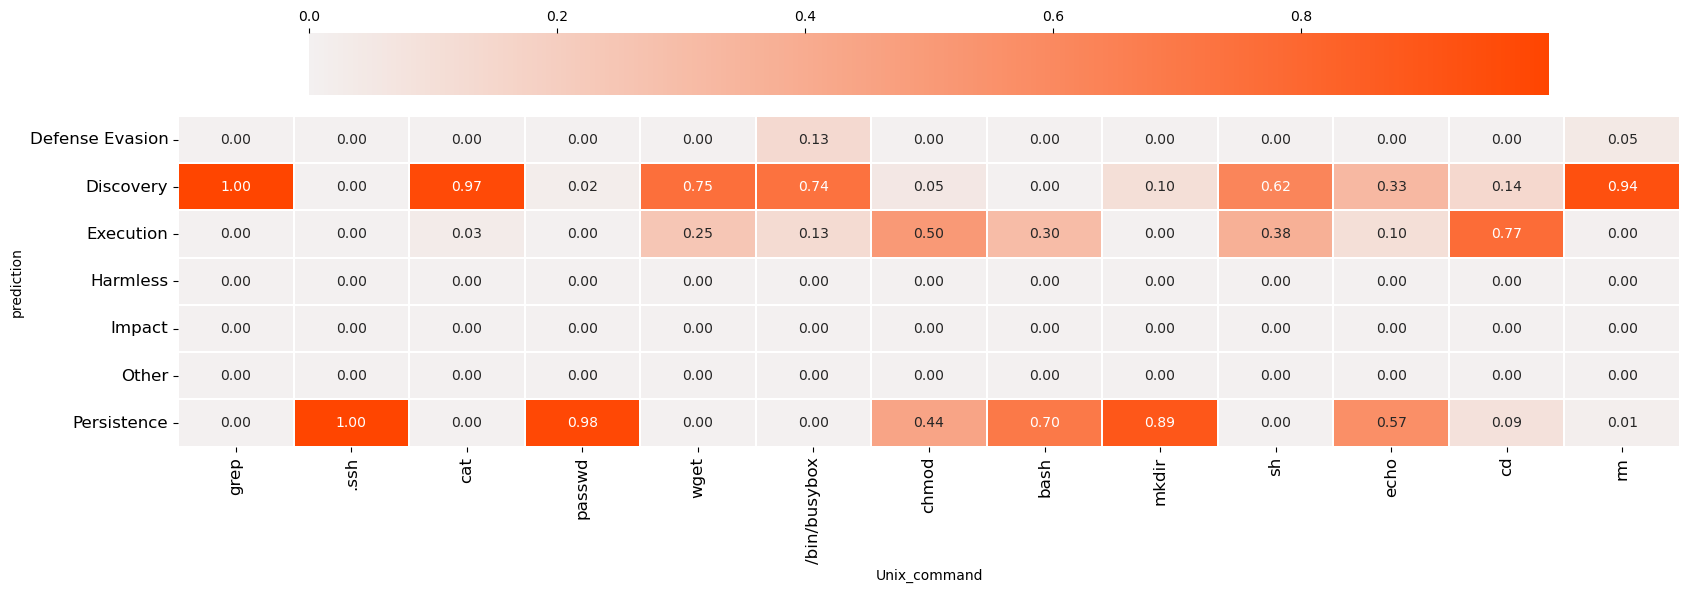

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axs = plt.subplots(1, figsize =(17, 6))
fontsize = 10
table = table.fillna(0)
palette = sns.color_palette("light:orangered", as_cmap=True)

im = sns.heatmap(table, linewidth = 0.1, cmap=palette, ax = axs, 
                annot = True, annot_kws={"fontsize":fontsize}, fmt='.2f', 
                cbar_kws={"orientation": "horizontal", "location":"top"})
axs.set_xticklabels(table.columns, fontsize = fontsize + 2, rotation = 90)
axs.set_yticklabels(table.index, fontsize = fontsize + 2, rotation = 0)
cbar = axs.collections[0].colorbar
cbar.ax.tick_params(labelsize=fontsize)
plt.tight_layout()